# Categorical VAE with ST Gumbel-Softmax

**Partial implementation of the paper [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) following the implementation from https://github.com/ericjang/gumbel-softmax but reorganized and translated to pure TF 2.2.**


## Imports and Helper Functions

In [1]:
import copy

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd

In [2]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

## Configuration

In [3]:
BATCH_SIZE=256
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5

## Gumbel softmax

Relaxed categorical distribution was recently added to TFP but before that sampling from it was relatively easy to achieve with the code presented below.

Through the notebook, *x* denotes observed data and *y* stands for latent samples.

In [4]:
@tf.function        
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random.uniform(shape,minval=0,maxval=1)
  return -tf.math.log(-tf.math.log(U + eps) + eps)


@tf.function   
def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)


@tf.function       
def straight_through_sample(y, hard):
  """
  Args:
    y: [..., n_class] one-hot sample from the Gumbel-Softmax distribution. 
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    If hard=True, then the returned sample y will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  if hard:
    K = y.shape[-1]
    y_hard = tf.cast(tf.one_hot(tf.argmax(y,-1), K), y.dtype)
    y = tf.stop_gradient(y_hard - y) + y  
  return y

## Model specification

There are two parameters configuring how the forward pass is performed:
 1. use_tfp_distributions - switches between using TFP RelaxedOneHotCategorical and the code above
 2. hard - turns on passing samples through straight-through (ST) estimator that converts them into 'true' one-hot encoded vectors

In [5]:
class CategoricalVAE(tf.Module):

    def __init__(self, N=10, K=2, hard=False, use_tfp_distributions=True, name=None):
        """
        
            Args:
                N: number of variables
                K: number of categories for each variable
                hard: set hard=True for ST Gumbel-Softmax 
                use_tfp_distributions: set True to represent q_y with RelaxedOneHotCategorical object 
                                        otherwise 
        """
        super(CategoricalVAE, self).__init__(name=name)

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        self.hard = hard # set hard=True for ST Gumbel-Softmax 
        # represent q_y with RelaxedOneHotCategorical object
        self.use_tfp_distributions = use_tfp_distributions 

        self.calc_logits_y = tf.keras.Sequential([ # encoder
                tf.keras.layers.Flatten(name="encoder0"),
                tf.keras.layers.Dense(512, activation="relu", 
                    input_shape=(None, 784), name="encoder1"),
                tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                tf.keras.layers.Reshape( [N,K] , name="encoder4")
                ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential([ # decoder
                tf.keras.layers.Flatten(name="decoder0"),
                tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                ], name="decoder") 
            
    def __call__(self, x, temperature=5.0):
        tau = tf.constant(temperature, name="temperature", dtype=tf.float32)                        
        
        # variational posterior q(y|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions 
        # (shape=(batch_size,N,K))
        logits_y = self.calc_logits_y(x)
        if self.use_tfp_distributions:
            q_y = tfpd.RelaxedOneHotCategorical(tau, logits=logits_y)
            y = q_y.sample()
        else:
            q_y = tf.nn.softmax(logits_y)                        
            y = gumbel_softmax_sample(logits_y, tau)  
        y = straight_through_sample(y, self.hard) # set hard=True for ST Gumbel-Softmax

        # generative model p(x|y)
        logits_x = self.calc_logits_x(y)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, q_y, y

## ELBOs with KL approximated in different ways

There are several issues that need to be considered when calculating KL term in ELBO for relaxed categorical distributions. This is because:
 1. Samples from the distribution (unless passed through ST) are not valid one-hot encoded vectors
 2. We cannot evaluate probability mass for categorical distribution - we get only probability density of its relaxed version
 
In consequence, certain decisions need to be made:
 1. How the priors should look like so they would make sense with relaxed latent samples *y*
 2. Do we try to estimate q(y) or do we approximate KL with MC as KL = y * (log q(y)-log p(y))

Finally, implementations differ between using TFP Relaxed Categorical distribution or the above code.

Below, we present three versions of the loss (-ELBO) with different choices regarding the issues.


In [6]:
def loss_analytical_relaxed_vs_categorical_notfp(x, p_x, q_y, *args, **kwargs):
    """ For KL uses densities q_y coming from concrete distribution. 
        that compares to categorical prior. 
        
        Based on
        https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
    """
    batch_size, K = p_x.logits.shape[0], q_y.shape[-1]
    N = int(tf.reduce_prod(q_y.shape)//K//batch_size)

    log_p_y = tf.math.log(1.0/K) * tf.ones_like(q_y) # compare to categorical
    log_q_y = tf.math.log(q_y+1e-20)        
    kl_tmp = q_y*(log_q_y-log_p_y)
    KL = tf.reduce_sum(kl_tmp, [1, 2])

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo) 

In [7]:
def loss_MC_relaxed_vs_relaxed(x, p_x, q_y, y): 
    """ For KL uses Monte Carlo KL with Relaxed (concrete) prior. 
    
        Based on
        https://github.com/ericjang/gumbel-softmax/blob/master/gumbel_softmax_vae_v2.ipynb
    """
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]
    
    tau = q_y.temperature # use the same temperature for prior as for posterior # TODO
    probs_py = tf.ones_like(q_y.logits) * 1./K  
    p_y = tfpd.RelaxedOneHotCategorical(tau, probs=probs_py) # compare to Relaxed (concrete)

    KL_qp = q_y.log_prob(y) - p_y.log_prob(y) #MC estimate
    KL = tf.reduce_sum(KL_qp, 1)

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo) 

In [8]:
def loss_analytical_relaxed_vs_categorical(x, p_x, q_y, *args, **kwargs):
    """ For KL uses Relaxed (concrete) distribution q_y 
        that compares to categorical prior. """
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]

    probs_py = tf.ones_like(q_y.logits) * 1./K  
    p_cat_y = tfpd.OneHotCategorical(probs=probs_py) # compare to categorical

    #KL_qp = tfpd.kl_divergence(q_y, p_cat_y) #not defined between Relaxed and OneHotCategorical
    #KL = tf.reduce_sum(KL_qp, 1)
    KL = tf.reduce_sum(q_y.probs_parameter() * (tf.math.log(q_y.probs_parameter()) - tf.math.log(p_cat_y.probs)), [2,1])

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo) 

## Training

We use MNIST data from Keras.

In [9]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

Create VAE and choose appropriate loss:

In [10]:
#loss = loss_MC_relaxed_vs_relaxed
#loss = loss_analytical_relaxed_vs_categorical
loss = loss_analytical_relaxed_vs_categorical_notfp

vae = CategoricalVAE(hard=True, use_tfp_distributions=False)

In [11]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
dat=[]
losses = []
best_loss, best_vae = float("inf"), None
i = 0

Training loop:

In [12]:
while i<NUM_ITERS:

    for np_x, labels in train_ds:
        
        with tf.GradientTape() as tape:        
            p_x, q_y, y = vae(np_x, temperature=np_temp)
            l = loss(np_x, p_x, q_y, y)
            losses.append(float(l)); 
        g = tape.gradient(l, vae.trainable_variables)
        optimizer.apply_gradients(zip(g, vae.trainable_variables))
        
        if i % 1000 == 1:
            np_temp = np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
            
        ########################################################################

        dat.append([i,np_temp,l])
    
        if i%100==0: 
            print("%i. loss=%.2f temp=%.2f" % (i, np.mean(losses), np_temp) )
            
            if np.mean(losses)<best_loss: # track the best over 100 iterations
                best_loss = np.mean(losses)
                best_vae = copy.deepcopy(vae)                        
        i += 1
        


0. loss=545.85 temp=1.00
100. loss=238.24 temp=1.00
200. loss=218.05 temp=1.00
300. loss=208.51 temp=1.00
400. loss=202.13 temp=1.00
500. loss=196.32 temp=1.00
600. loss=190.99 temp=1.00
700. loss=186.03 temp=1.00
800. loss=181.93 temp=1.00
900. loss=178.51 temp=1.00
1000. loss=175.52 temp=1.00
1100. loss=173.05 temp=0.97
1200. loss=170.86 temp=0.97
1300. loss=169.00 temp=0.97
1400. loss=167.34 temp=0.97
1500. loss=165.89 temp=0.97
1600. loss=164.58 temp=0.97
1700. loss=163.35 temp=0.97
1800. loss=162.28 temp=0.97
1900. loss=161.28 temp=0.97
2000. loss=160.39 temp=0.97
2100. loss=159.57 temp=0.94
2200. loss=158.78 temp=0.94
2300. loss=158.09 temp=0.94
2400. loss=157.40 temp=0.94
2500. loss=156.80 temp=0.94
2600. loss=156.21 temp=0.94
2700. loss=155.68 temp=0.94
2800. loss=155.17 temp=0.94
2900. loss=154.68 temp=0.94
3000. loss=154.23 temp=0.94
3100. loss=153.78 temp=0.91
3200. loss=153.39 temp=0.91
3300. loss=153.00 temp=0.91
3400. loss=152.63 temp=0.91
3500. loss=152.30 temp=0.91
3600

28700. loss=137.93 temp=0.50
28800. loss=137.92 temp=0.50
28900. loss=137.92 temp=0.50
29000. loss=137.91 temp=0.50
29100. loss=137.90 temp=0.50
29200. loss=137.89 temp=0.50
29300. loss=137.89 temp=0.50
29400. loss=137.88 temp=0.50
29500. loss=137.87 temp=0.50
29600. loss=137.87 temp=0.50
29700. loss=137.86 temp=0.50
29800. loss=137.85 temp=0.50
29900. loss=137.85 temp=0.50
30000. loss=137.84 temp=0.50
30100. loss=137.83 temp=0.50
30200. loss=137.83 temp=0.50
30300. loss=137.83 temp=0.50
30400. loss=137.82 temp=0.50
30500. loss=137.82 temp=0.50
30600. loss=137.81 temp=0.50
30700. loss=137.81 temp=0.50
30800. loss=137.80 temp=0.50
30900. loss=137.80 temp=0.50
31000. loss=137.79 temp=0.50
31100. loss=137.78 temp=0.50
31200. loss=137.78 temp=0.50
31300. loss=137.78 temp=0.50
31400. loss=137.77 temp=0.50
31500. loss=137.77 temp=0.50
31600. loss=137.77 temp=0.50
31700. loss=137.76 temp=0.50
31800. loss=137.76 temp=0.50
31900. loss=137.76 temp=0.50
32000. loss=137.75 temp=0.50
32100. loss=13

In [13]:
# use the best from observed
vae = best_vae            

## Training Curves

In [24]:
dat=np.array(dat).T

(90, 185)

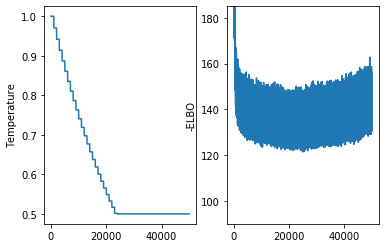

In [40]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')
axarr[1].set_ylim((90,185))

## Reconstruction

In [37]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt

In [38]:
np_x1 = x_train[-BATCH_SIZE:]
p_x, q_y, y = vae(np_x1)
np_x2 = p_x.mean()


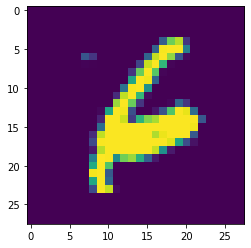

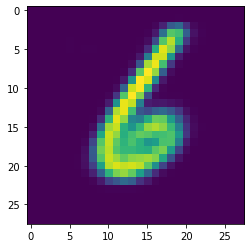

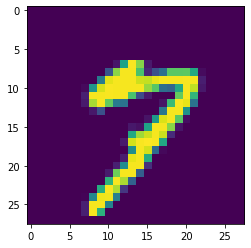

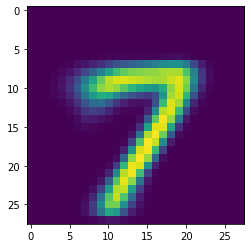

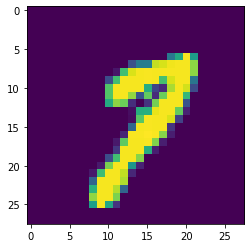

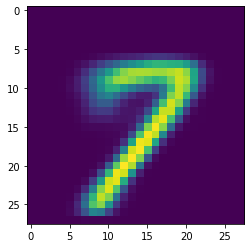

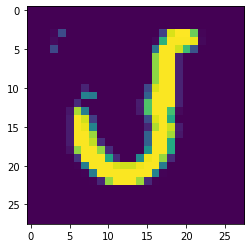

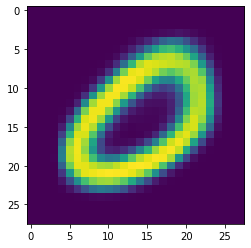

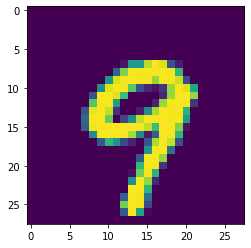

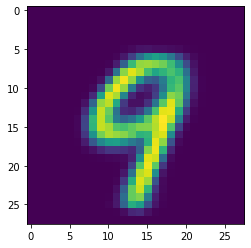

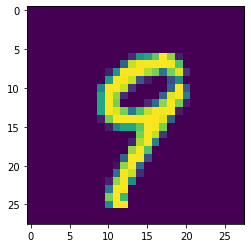

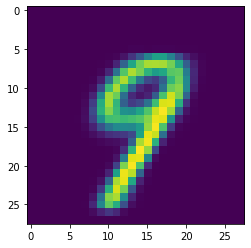

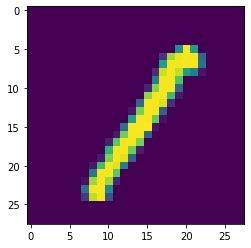

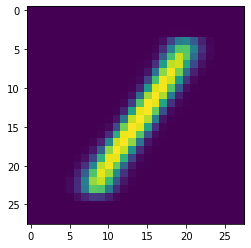

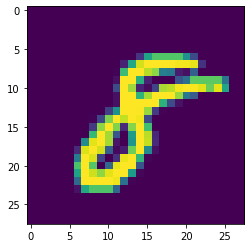

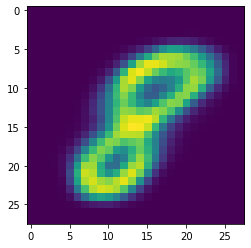

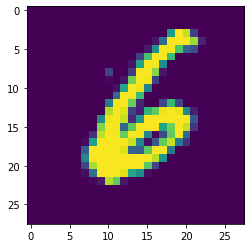

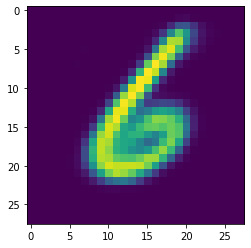

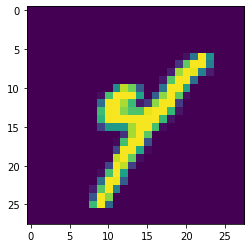

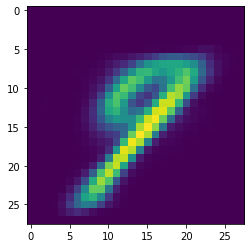

In [39]:
for i in range(10):
    plt.imshow(np_x1[i].numpy().reshape((28,28))); plt.show()
    plt.imshow(np_x2[i].numpy().reshape((28,28))); plt.show()

## Unconditional generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through decoder of the model.

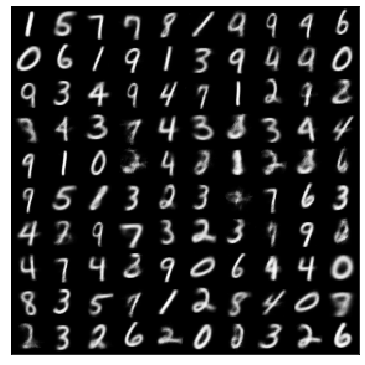

In [44]:
np.random.seed(0)
ys = []
for _ in range(10):
    xs = []
    for _ in range(10):
        np_y = np.zeros((N,K))
        np_y[range(N),np.random.choice(K,N)] = 1
        np_y = np.reshape(np_y,[1,N,K])

        logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
        p_x = tfp.distributions.Bernoulli(logits=logits_x)
        np_x = p_x.mean().numpy()[0].reshape((28,28))
        xs.append(np_x)
    ys.append(np.hstack(xs))
img = np.vstack(ys)   

fig = plt.figure(figsize=(6.4, 6.4), dpi=72)
plt.imshow(img, cmap=plt.cm.gray,interpolation='none')
plt.xticks([],{})
plt.yticks([],{})
plt.savefig("vae_concrete.pdf", bbox_inches = 'tight', pad_inches =0)